<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visuelle Regressionstest mit Autoencodern

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
# mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [3]:
import numpy as np
np.random.seed(42)

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.4.0'

In [5]:
tf.random.set_seed(42)

In [6]:
#!nvidia-smi

In [7]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [8]:
from lrcurve import KerasLearningCurve

# Schritt 1: Laden und Aufbereitung der Daten

In [9]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/golden-master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7589k  100 7589k    0     0  10.1M      0 --:--:-- --:--:-- --:--:-- 10.1M


In [10]:
#!unzip -jqo golden-master.zip -d train

In [11]:
# !ls train

In [12]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/app-testing/regression.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  830k  100  830k    0     0  2541k      0 --:--:-- --:--:-- --:--:-- 2539k


In [13]:
#!unzip -jqo regression.zip -d test

In [14]:
# !ls -l test

In [15]:
# Für eine symmetrische Form des Autoencoders ist eine Zweierpotenz für die Auflösung am einfachsten
x_res, y_res = (256, 256)

In [16]:
import os
import numpy as np
from skimage import data, io, filters
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.color import rgb2gray

def read_images_from_dir(data_dir, dims=(356, 384), type = ".png"):
  x_dim, y_dim = dims
  images = []
  file_names = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(type)]
  for f in file_names:
    image = io.imread(f)
    # some images from regressed application often have an additional line break
    # we take the easy route and simply clip to have the same size for all images
    image = image[:x_dim, :y_dim, :3]
    image = rgb2gray(image)
    image = resize(image, (x_res, y_res))
    images.append(image)

  images = np.array(images)

  return images

In [17]:
train = read_images_from_dir("train")
train.shape, train.dtype

((603, 256, 256), dtype('float64'))

In [18]:
test = read_images_from_dir("test")
test.shape, test.dtype

((51, 256, 256), dtype('float64'))

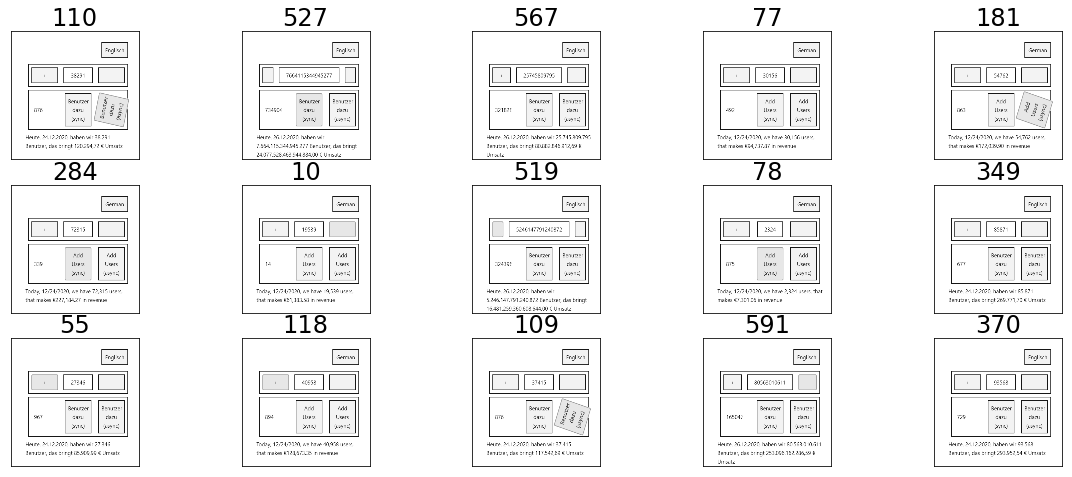

In [19]:
def plot_samples(x, n_samples=15):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index], cmap="gray")
      ax.set_title("{}".format(index))
        
plot_samples(train)

# Schritt 2: Training des Autoencoders

* Encoder nutzt gewöhnliche Convolutional Layers
* Decoder nutzt das Gegenstück: Deconvoluation Layers
* Der Flaschenhals nutzt lediglich 8 Neuronen, diese können aber einfach konfiguriert werden. Weniger als 8 wird wahrscheinlich nicht trainieren
* Wir nutzen eine spezielle Accuracy, die zählt, wie viele Pixel stimmen wenn man das Problem aus S/W reduziert

In [20]:
from tensorflow import keras

# gerundet auf s/w wie viele Pixel kommen ungefähr hin?
# übernommen aus: https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb#scrollTo=vTfcqDgW-Kff
@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [21]:
# Dimension des Flaschenhalses
# geringer als 8 gibt es wenige Erfolgsaussichten
encoding_dim = 8

In [22]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential

from tensorflow import keras

kernel_size = 4
stride = 2

encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    Conv2D(1, kernel_size=kernel_size, strides=1, padding="same"),
    Flatten(),
    # latent representation
    Dense(encoding_dim, activation="linear")

])
decoder = Sequential([
    # accepts the latent representation
    Input(shape=(encoding_dim)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(8, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(16, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(32, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(64, kernel_size=kernel_size, strides=stride, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Conv2DTranspose(1, kernel_size=kernel_size, strides=1, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", 
                optimizer='adam', 
                metrics=[rounded_accuracy])

# encoder.summary()
# decoder.summary()

In [23]:
from tensorflow.keras.utils import plot_model
# plot_model(encoder, to_file="encoder.png", show_shapes=True, show_layer_names=False, dpi=300)
plot_model(encoder, show_shapes=True, show_layer_names=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
# plot_model(decoder, to_file="decoder.png", show_shapes=True, show_layer_names=False, dpi=300)
plot_model(decoder, show_shapes=True, show_layer_names=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [25]:
%%time

# bring this down if training does not work any more
# can be higher when dimeension of hidden representation is higher
BATCH_SIZE = 4
# typically is more than enough
# Original EPOCHS = 100 dauert auf CPU viel zu lange
EPOCHS = 10

history = autoencoder.fit(train, train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(test, test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

Wall time: 5min 16s


In [26]:
train_loss, train_accuracy = autoencoder.evaluate(train, train, batch_size=BATCH_SIZE, verbose=0)
train_accuracy

0.9798962473869324

In [27]:
test_loss, test_accuracy = autoencoder.evaluate(test, test, batch_size=BATCH_SIZE, verbose=0)
test_accuracy

0.9727702140808105

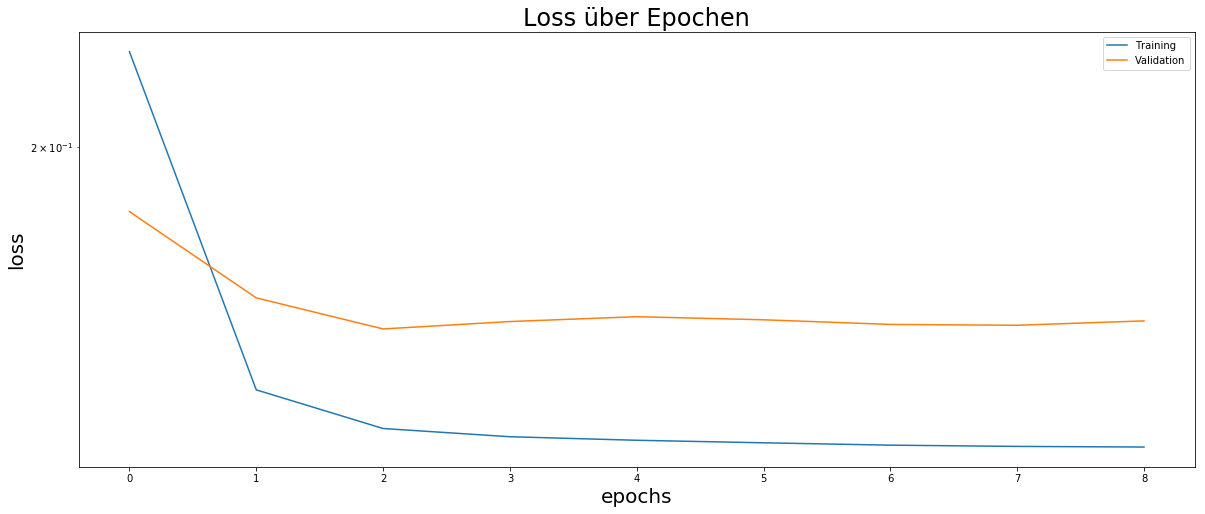

In [28]:
START_EPOCHE = 0
END_EPOCHE = -1

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss über Epochen')

plt.plot(history.history['loss'][START_EPOCHE:END_EPOCHE]);
plt.plot(history.history['val_loss'][START_EPOCHE:END_EPOCHE]);

plt.legend(['Training', 'Validation']);

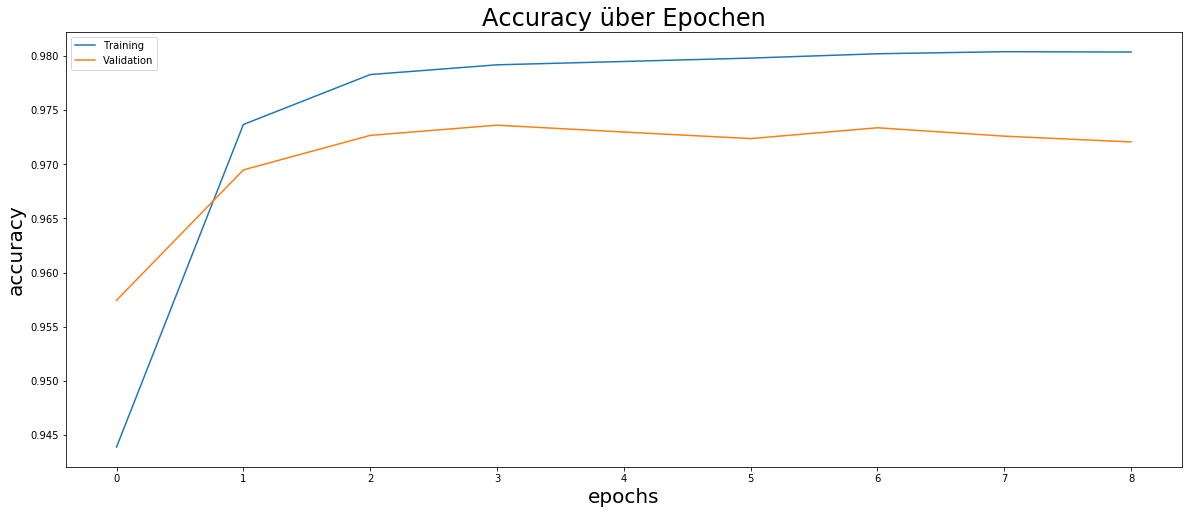

In [29]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy über Epochen')

plt.plot(history.history['rounded_accuracy'][START_EPOCHE:END_EPOCHE])
plt.plot(history.history['val_rounded_accuracy'][START_EPOCHE:END_EPOCHE])

plt.legend(['Training', 'Validation']);

# Schritt 3: Ergebnisse überprüfen

In [30]:
train_pred = autoencoder.predict(train)

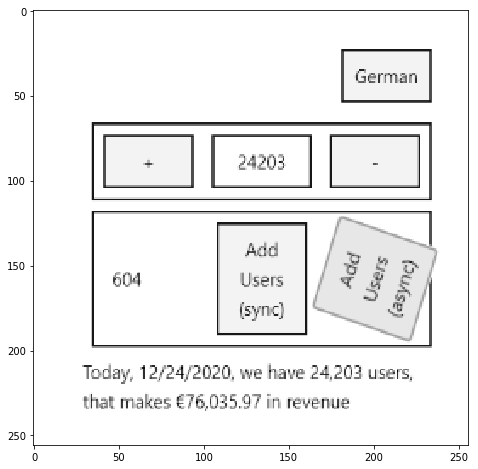

In [31]:
index = 50
plt.imshow(train[index], cmap='gray')
# io.imsave('train_true.png', train[index])

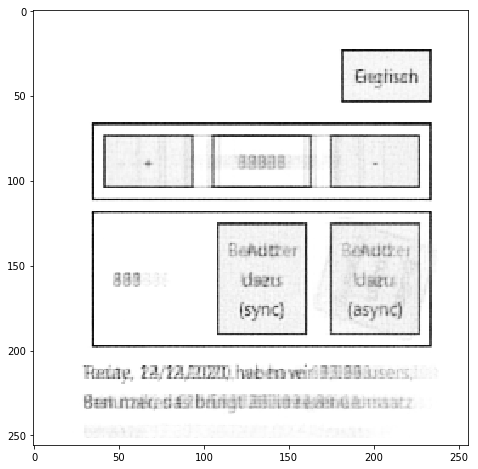

In [32]:
plt.imshow(train_pred[index], cmap='gray')
# io.imsave('train_pred.png', train_pred[index])

In [33]:
def rounded_accuracy_for_single_image(true, predicted):
  return tf.reduce_mean(rounded_accuracy(true, predicted.astype('float64'))).numpy()    

In [34]:
rounded_accuracy_for_single_image(train[50], train_pred[50])

0.98002625

In [35]:
test_pred = autoencoder.predict(test)

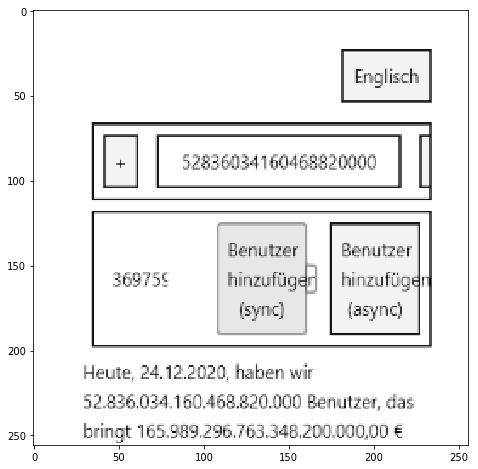

In [36]:
index = 21
# index = 24
plt.imshow(test[index], cmap='gray')
# io.imsave('test_true.png', test[index])

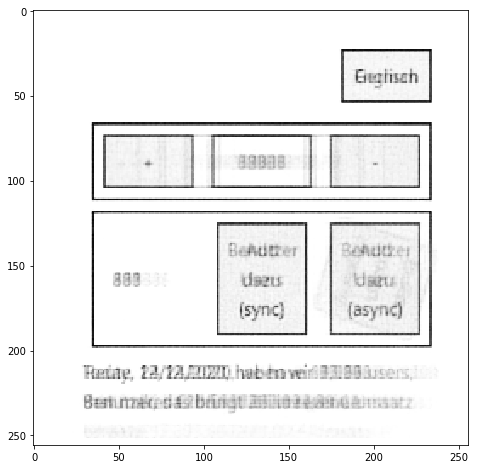

In [37]:
plt.imshow(test_pred[index], cmap='gray')
# io.imsave('test_pred.png', test_pred[index])

In [38]:
rounded_accuracy_for_single_image(test[0], test_pred[0])

0.9840393

## Training Set

In [39]:
def compare_samples(x, x_pred, n_samples=5):
  n_samples = min(n_samples, len(x))
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x.shape[0], size=n_samples, replace=False)):
      acc = rounded_accuracy_for_single_image(x[index], x_pred[index])
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.set_title("{}".format(index))
      ax.imshow(x[index], cmap="gray")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.set_title("{:.4f}".format(acc))
      ax.imshow(x_pred[index], cmap="gray")

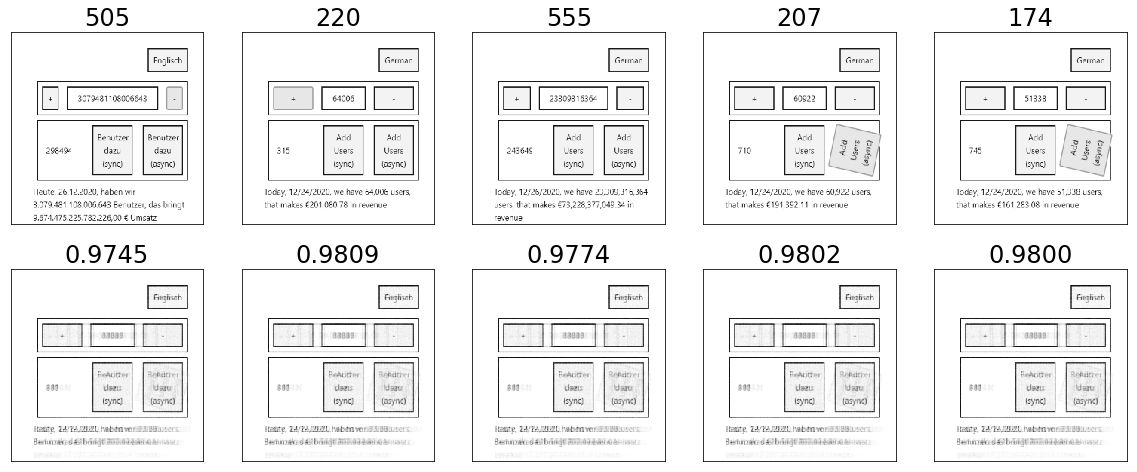

In [40]:
compare_samples(train, train_pred)

In [41]:
scores = []
for true_image, predicted_image in zip(train, train_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
train_scores = np.array(scores)  
train_scores.shape

(603,)

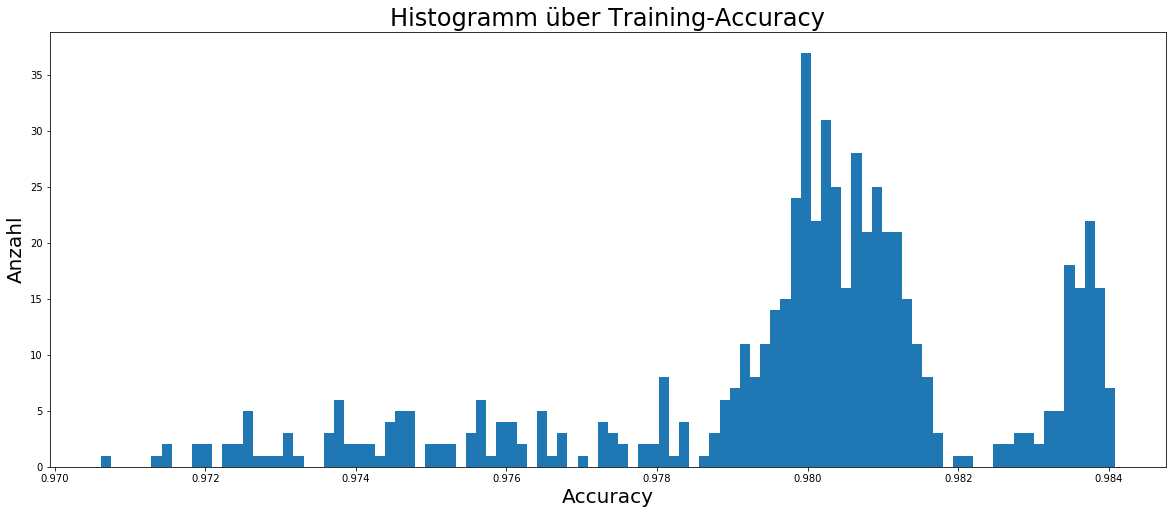

In [42]:
plt.title('Histogramm über Training-Accuracy')
plt.ylabel("Anzahl")
plt.xlabel("Accuracy")

plt.hist(train_scores, bins=100);

## Test Set

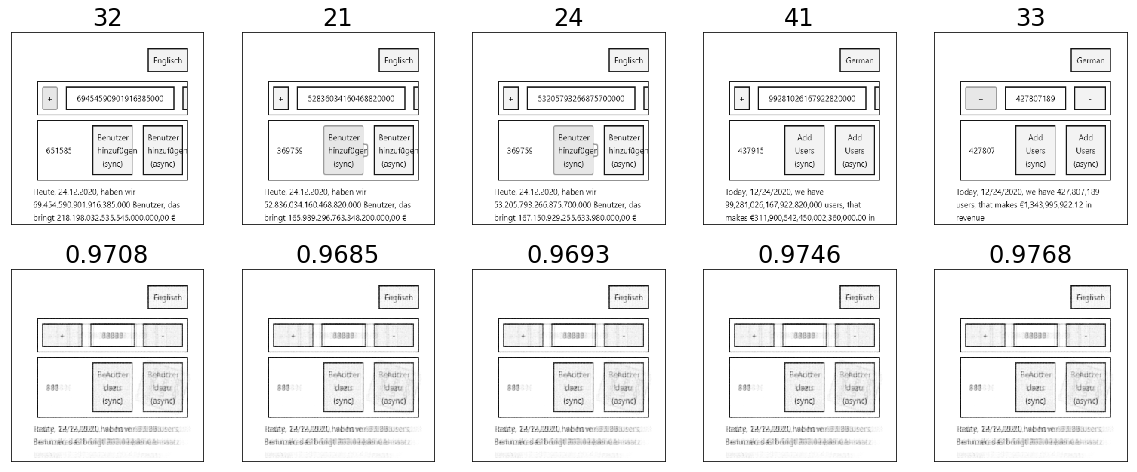

In [43]:
compare_samples(test, test_pred)

In [44]:
scores = []
for true_image, predicted_image in zip(test, test_pred):
  score = rounded_accuracy_for_single_image(true_image, predicted_image)
  scores.append(score)
test_scores = np.array(scores)  
test_scores.shape

(51,)

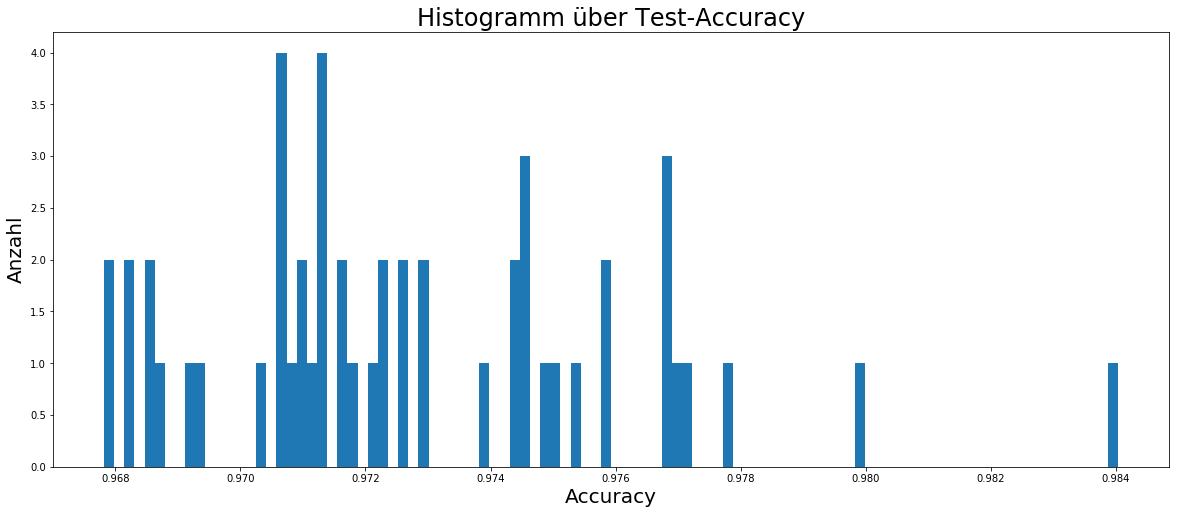

In [45]:
plt.title('Histogramm über Test-Accuracy')
plt.ylabel("Anzahl")
plt.xlabel("Accuracy")

plt.hist(test_scores, bins=100);

# Schritt 4: Verdächtige Screenshots identifizieren

Verdächtige Screenshots: 51 von 51


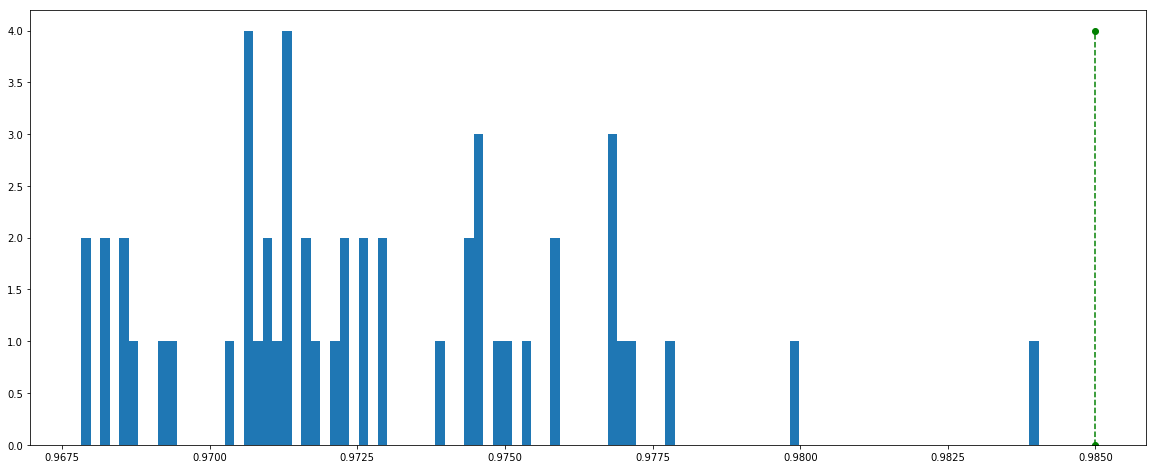

In [46]:
#@title Schwellwert: unterhalb welcher Übereinstimmung sehen wir einen Screenshot als verdächtig an? { run: "auto", display-mode: "both"  }

threshold = 0.985 #@param {type:"slider", min:0.97, max:1.0, step:0.0001}
test_mask = test_scores < threshold
n, _, _ = plt.hist(test_scores, bins=100)
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');
print("Verdächtige Screenshots: {:d} von {:d}".format(np.count_nonzero(test_mask), test_mask.shape[0]));

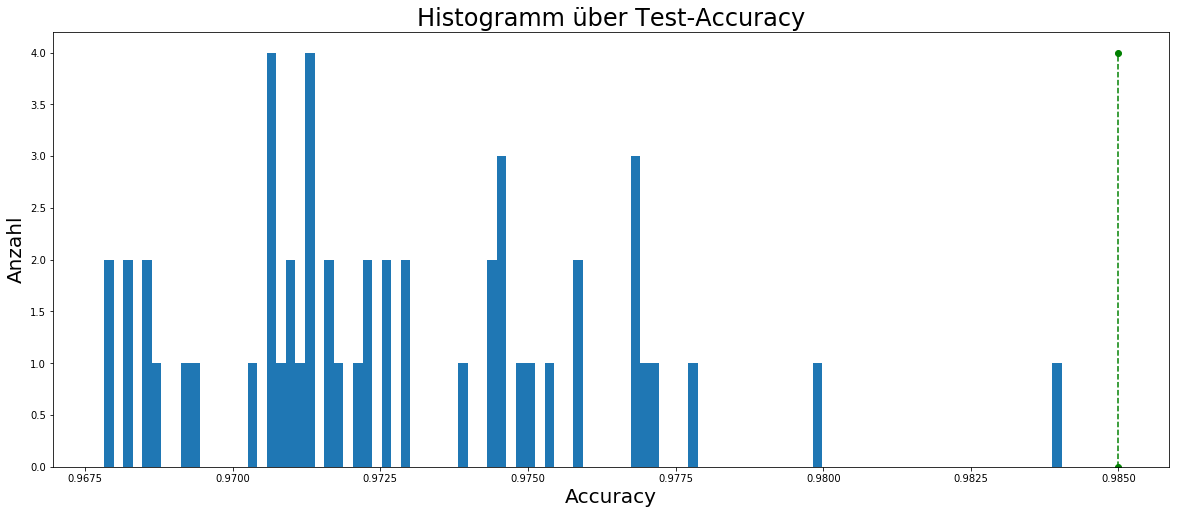

In [47]:
plt.title('Histogramm über Test-Accuracy')
plt.ylabel("Anzahl")
plt.xlabel("Accuracy")

n, _, _ = plt.hist(test_scores, bins=100)
plt.plot((threshold, threshold), (0, n.max()),  color='green', marker='o', linestyle='dashed');

## Unverdächtige Screenshots

In [48]:
compare_samples(test[~test_mask], test_pred[~test_mask])

<Figure size 1440x576 with 0 Axes>

## Verdächtige Screenshots

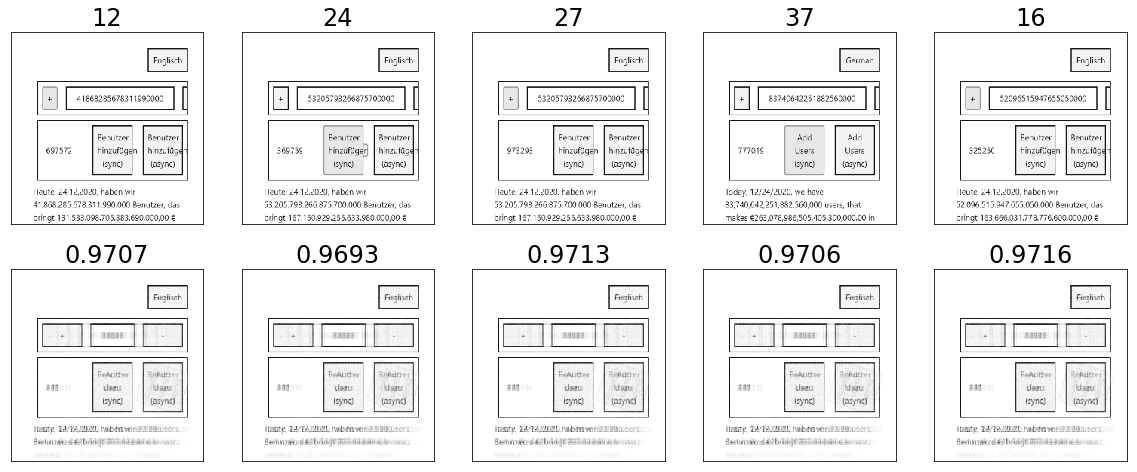

In [49]:
compare_samples(test[test_mask], test_pred[test_mask])